In [1]:
import numpy as np
from scipy.spatial import distance
import itertools

from CSW import CSWTask

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from tensorflow import keras as kr
from tensorflow.keras import layers

In [3]:
def init_net(env_size,env_dim,tsteps,hid_dim):
  """ create a model 
  """
  # input layer
  inputs = kr.Input(shape=(tsteps,env_dim), dtype="float32")
  # dense in
  x = layers.Dense(hid_dim, activation="linear")(inputs)
  # rnn
  x,h,c = kr.layers.LSTM(hid_dim, 
                         return_sequences=True,
                         unroll=False,
                         return_state=True,
                         )(x,initial_state=None)
  # dense out
  outputs = layers.Dense(env_dim, activation="linear")(x)
  model = kr.Model(inputs, outputs)
  return model


In [4]:
def train_and_eval(nnets=3,block_len0=40,learn_rate=0.05,hid_dim=35):
  # net params
  env_dim = 12
  env_size = 12 
  tsteps = 5
  # task params
  neps = 200

  # task
  taskL = [CSWTask(1),CSWTask(0)]
  # embedding matrix
  Emat = np.random.normal(0,1,[env_size,env_dim]).astype('float32')
  # init  eval array
  num_probes = 2 
  acc = -np.ones([nnets,neps,num_probes]) 

  # loss and optimizer
  loss_fn = kr.losses.MeanSquaredError()
  optimizer = kr.optimizers.Adam(learning_rate=learn_rate)

  for seed in range(nnets):
    model = init_net(env_size,env_dim,tsteps,hid_dim)
    task_int = 0
    for ep in range(neps):
      block_len = block_len0 
      # controls test phase
      if ep >= 160:
        block_len = 1
      # select graph
      if ep%block_len==0:
        task_int = (task_int+1)%2
        task = taskL[task_int]
        filler_id = 10+task_int 
      # sample path from graph
      path = task.sample_path()
      # format for neural network input
      xtrain,ytrain = task.dataset_onestory_with_marker(path=path,filler_id=filler_id,depth=1,keras=True)
      # embed 
      xtrain,ytrain = Emat[xtrain],Emat[ytrain]
      # compute loss in tape
      with tf.GradientTape() as tape:
        yhat = model(xtrain,training=True)
        loss_value = loss_fn(ytrain, yhat)
      # eval 
      acc[seed,ep,0] = distance.cosine(yhat.numpy()[0,3],ytrain[0,3])
      acc[seed,ep,1] = distance.cosine(yhat.numpy()[0,4],ytrain[0,4])
      # update weights
      grads = tape.gradient(loss_value, model.trainable_weights)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))
  return acc



In [5]:
# simulation specific params
nnets = 10
learn_rate=0.05
hid_dim=35

In [6]:
acc_i = train_and_eval(nnets,1,learn_rate,hid_dim)
acc_b = train_and_eval(nnets,40,learn_rate,hid_dim)

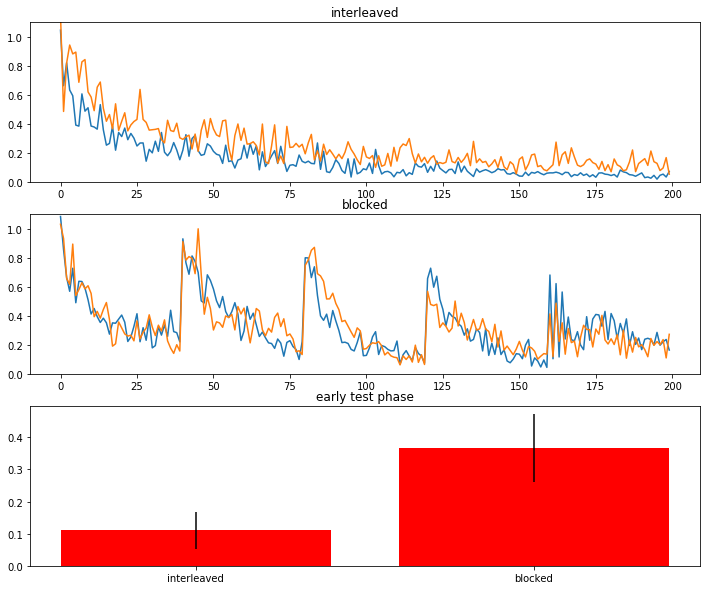

In [8]:
fig,axarr = plt.subplots(3,1,figsize=(12,10))
# line plt
# interleaved
ax = axarr[0]
ax.set_title('interleaved')
ax.plot(acc_i.mean(0))
# blocked
ax = axarr[1]
ax.set_title('blocked')
ax.plot(acc_b.mean(0))
for ax in axarr[:2]:
  ax.set_ylim(0,1.1)
# bar plt
ax = axarr[2]
ax.set_title('early test phase')
Mi = acc_i[:,-40:-35,:].mean()
Si = acc_i[:,-40:-35,:].std()/np.sqrt(nnets)
Mb = acc_b[:,-40:-35,:].mean()
Sb = acc_b[:,-40:-35,:].std()/np.sqrt(nnets)
ax.bar([1,2],[Mi,Mb],yerr=[Si,Sb],color='r')
ax.set_xticks([1,2])
ax.set_xticklabels(['interleaved','blocked'])
plt.savefig('matchSEM/keras/cosine_dist_yhat_ytarget_cos')